In [1]:
import json
import csv
import pandas as pd
import numpy as np
import scipy as sci
import keras
from keras.models import Sequential
from keras import regularizers
from keras.layers.core import Dense, Activation
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import io
import requests
import tensorflow as tf
from scipy import sparse
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os

C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Useful Functions

In [2]:
#Function to normalize columns
def normalize_numeric_minmax(df, name):
        df[name] = ((df[name] - df[name].min()) / (df[name].max() - df[name].min())).astype(np.float32)
    

In [3]:
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
import collections
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [4]:
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


# Data Pre-Processing

In [5]:
#Read Stock_Price_MAX.csv file and load data into stock_df dataframe 
stock_df= pd.read_csv('Stock_Price_MAX.csv')
stock_df

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600
5,2000/4/3,3.500000,3.703125,3.437500,3.437500,3.437500,11486800
6,2000/4/4,3.531250,3.578125,3.093750,3.500000,3.500000,13136800
7,2000/4/5,3.468750,3.562500,3.453125,3.484375,3.484375,6349600
8,2000/4/6,3.500000,3.593750,3.468750,3.578125,3.578125,7181200
9,2000/4/7,3.593750,3.812500,3.593750,3.609375,3.609375,13904800


In [6]:
stock_df = stock_df.drop(['Date', 'Adj_Close'], axis = 1)
stock_df

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600
5,3.500000,3.703125,3.437500,3.437500,11486800
6,3.531250,3.578125,3.093750,3.500000,13136800
7,3.468750,3.562500,3.453125,3.484375,6349600
8,3.500000,3.593750,3.468750,3.578125,7181200
9,3.593750,3.812500,3.593750,3.609375,13904800


In [7]:
# Normalize the columns
    
normalize_numeric_minmax(stock_df,"Open")
normalize_numeric_minmax(stock_df,"High") 
normalize_numeric_minmax(stock_df,"Low") 
normalize_numeric_minmax(stock_df,"Volume") 
normalize_numeric_minmax(stock_df,"Close") 
stock_df

,Open,High,Low,Close,Volume
0,0.004378,0.006469,0.006934,0.007408,0.075401
1,0.007031,0.006205,0.008535,0.006482,0.019194
2,0.005970,0.005413,0.008135,0.006350,0.005339
3,0.005970,0.005149,0.007201,0.005027,0.036632
4,0.003714,0.002904,0.003334,0.001191,0.167478
5,0.001725,0.002640,0.003734,0.001588,0.244393
6,0.001990,0.001584,0.000800,0.002117,0.280091
7,0.001459,0.001452,0.003867,0.001984,0.133252
8,0.001725,0.001716,0.004001,0.002778,0.151243
9,0.002521,0.003564,0.005067,0.003043,0.296706


In [8]:
# to xy to convert pandas to tensor flow
x,y=to_xy(stock_df,"Close")

# Fully Connected Neural Network

In [9]:
#Split for train and test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [10]:
x_train.shape

(3074, 4)

In [11]:
x_test.shape

(1318, 4)

In [12]:
y_train.shape

(3074,)

In [13]:
y_test.shape

(1318,)

## ReLU

### ReLU, adam, 2 layers, early stopping and Model checkpoint  - score_relu_2l

In [14]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_2l.hdf5", verbose=1, save_best_only=True)

In [16]:
# relu adam 2 layers
for i in range(10):
    print(i)
    
    # Build network
    model_relu = Sequential()
    model_relu.add(Dense(60, input_dim=x_train.shape[1], activation='relu')) 
    model_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_relu.load_weights('./best_weights_relu_2l.hdf5')


0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 0s - loss: 0.0204 - val_loss: 2.3760e-05

Epoch 00001: val_loss did not improve from 0.00001
Epoch 2/100
 - 0s - loss: 1.8422e-05 - val_loss: 1.3914e-05

Epoch 00002: val_loss did not improve from 0.00001
Epoch 3/100
 - 0s - loss: 1.4787e-05 - val_loss: 1.1761e-05

Epoch 00003: val_loss did not improve from 0.00001
Epoch 4/100
 - 0s - loss: 1.4215e-05 - val_loss: 1.4637e-05

Epoch 00004: val_loss did not improve from 0.00001
Epoch 5/100
 - 0s - loss: 1.4475e-05 - val_loss: 1.2886e-05

Epoch 00005: val_loss did not improve from 0.00001
Epoch 6/100
 - 0s - loss: 1.5416e-05 - val_loss: 1.1412e-05

Epoch 00006: val_loss did not improve from 0.00001
Epoch 00006: early stopping
1
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 0s - loss: 0.0366 - val_loss: 9.2198e-05

Epoch 00001: val_loss did not improve from 0.00001
Epoch 2/100
 - 0s - loss: 7.7213e-05 - val_loss: 4.9110e-05

Epoch 00002: val_loss did not impro

In [17]:
# Predict stars
pred_relu_2l = model_relu.predict(x_test)
print("Shape: {}".format(pred_relu_2l.shape))


Shape: (1318, 1)


In [18]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_2l = np.sqrt(mean_squared_error(y_test,pred_relu_2l))
print("Final score (RMSE): {}".format(score_relu_2l))
print('R2 score: %.2f' % r2_score(y_test, pred_relu_2l))

Final score (RMSE): 0.002840494504198432
R2 score: 1.00


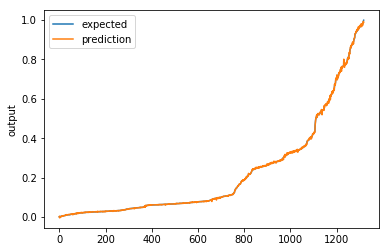

In [54]:
#Regression lift Chart
chart_regression(pred_relu_2l.flatten(),y_test)

### ReLU, adam, 3 layer, early stopping and Model checkpoint  - score_relu_3l

In [28]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_adam3l.hdf5", verbose=1, save_best_only=True)

In [30]:
for i in range(10):
    print(i)
    
    # Build network
    model_relu = Sequential()
    model_relu.add(Dense(60, input_dim=x_train.shape[1], activation='relu')) 
    model_relu.add(Dense(30, activation='relu')) # Hidden 3
    model_relu.add(Dense(10, activation='relu')) # Hidden 2
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_relu.load_weights('./best_weights_relu_adam3l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 65s - loss: 0.0126 - val_loss: 3.0639e-05

Epoch 00001: val_loss did not improve from 0.00001
Epoch 2/100
 - 4s - loss: 1.8908e-05 - val_loss: 1.4346e-05

Epoch 00002: val_loss did not improve from 0.00001
Epoch 3/100
 - 4s - loss: 1.4121e-05 - val_loss: 2.3661e-05

Epoch 00003: val_loss did not improve from 0.00001
Epoch 4/100
 - 4s - loss: 1.4136e-05 - val_loss: 1.4523e-05

Epoch 00004: val_loss did not improve from 0.00001
Epoch 5/100
 - 4s - loss: 1.2806e-05 - val_loss: 1.2274e-05

Epoch 00005: val_loss did not improve from 0.00001
Epoch 6/100
 - 4s - loss: 1.3352e-05 - val_loss: 1.8535e-05

Epoch 00006: val_loss did not improve from 0.00001
Epoch 00006: early stopping
1
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 68s - loss: 0.0160 - val_loss: 3.4665e-05

Epoch 00001: val_loss did not improve from 0.00001
Epoch 2/100
 - 4s - loss: 2.5128e-05 - val_loss: 2.1308e-05

Epoch 00002: val_loss did not imp

In [31]:
# Predict stars
pred_hl_3 = model_relu.predict(x_test)

In [32]:
# Measure RMSE error.  RMSE is common for regression.
score_3l = np.sqrt(mean_squared_error(y_test,pred_hl_3))
print("Final score (RMSE): {}".format(score_3l))
print('R2 score: %.2f' % r2_score(y_test, pred_hl_3))

Final score (RMSE): 0.0031694588251411915
R2 score: 1.00


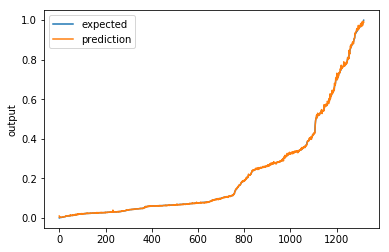

In [55]:
#Regression lift Chart
chart_regression(pred_hl_3.flatten(),y_test)

### ReLU, adam, 4 layer, early stopping and Model checkpoint  - score_relu_4l

In [33]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_adam4l.hdf5", verbose=1, save_best_only=True)

In [34]:
for i in range(10):
    print(i)
    
    # Build network
    model_relu = Sequential()

    model_relu.add(Dense(80, input_dim=x_train.shape[1], activation='relu'))  
    model_relu.add(Dense(60, activation='relu')) # Hidden 2
    model_relu.add(Dense(20, activation='relu')) # Hidden 3
    model_relu.add(Dense(10, activation='relu')) # Hidden 4
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_relu.load_weights('./best_weights_relu_adam4l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 71s - loss: 0.0126 - val_loss: 1.5947e-05

Epoch 00001: val_loss improved from inf to 0.00002, saving model to ./best_weights_relu_adam4l.hdf5
Epoch 2/100
 - 4s - loss: 1.7409e-05 - val_loss: 1.1150e-05

Epoch 00002: val_loss improved from 0.00002 to 0.00001, saving model to ./best_weights_relu_adam4l.hdf5
Epoch 3/100
 - 4s - loss: 1.7748e-05 - val_loss: 1.5071e-05

Epoch 00003: val_loss did not improve from 0.00001
Epoch 4/100
 - 4s - loss: 2.4391e-05 - val_loss: 1.0811e-05

Epoch 00004: val_loss improved from 0.00001 to 0.00001, saving model to ./best_weights_relu_adam4l.hdf5
Epoch 5/100
 - 4s - loss: 2.0537e-05 - val_loss: 2.4486e-05

Epoch 00005: val_loss did not improve from 0.00001
Epoch 6/100
 - 4s - loss: 2.0998e-05 - val_loss: 2.6306e-05

Epoch 00006: val_loss did not improve from 0.00001
Epoch 00006: early stopping
1
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 70s - loss: 0.0094 - val_loss: 2.

In [35]:
# Predict stars
pred_hl4 = model_relu.predict(x_test)

In [36]:
# Measure RMSE error.  RMSE is common for regression.
score_4l = np.sqrt(mean_squared_error(y_test,pred_hl4))
print("Final score (RMSE): {}".format(score_4l))
print('R2 score: %.2f' % r2_score(y_test, pred_hl4))

Final score (RMSE): 0.0030393151100724936
R2 score: 1.00


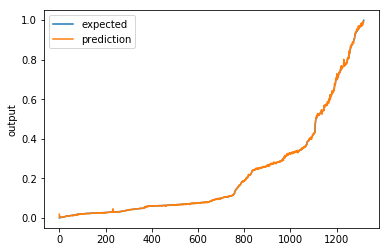

In [56]:
#Regression lift Chart
chart_regression(pred_hl4.flatten(),y_test)

### ReLU, adam, 4 layer and dropout - score_relu_4l_do

In [37]:
    # Build network
    model_relu = Sequential()

    model_relu.add(Dense(80, input_dim=x_train.shape[1]))  
    model_relu.add(Dropout(0.1))
    model_relu.add(Dense(60, activation='relu')) # Hidden 2
    model_relu.add(Dense(20, activation='relu')) # Hidden 3
    model_relu.add(Dense(10, activation='relu')) # Hidden 4
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 73s - loss: 0.0178 - val_loss: 7.7647e-05
Epoch 2/100
 - 4s - loss: 3.6149e-04 - val_loss: 3.2215e-05
Epoch 3/100
 - 4s - loss: 2.8882e-04 - val_loss: 1.8829e-05
Epoch 4/100
 - 4s - loss: 2.6489e-04 - val_loss: 6.7529e-05
Epoch 5/100
 - 4s - loss: 2.1587e-04 - val_loss: 4.7460e-05
Epoch 6/100
 - 4s - loss: 2.1101e-04 - val_loss: 1.0191e-04
Epoch 00006: early stopping


In [38]:
# Predict stars
pred_hl4_do = model_relu.predict(x_test)

In [39]:
# Measure RMSE error.  RMSE is common for regression.
score_4l_do = np.sqrt(mean_squared_error(y_test,pred_hl4_do))
print("Final score (RMSE): {}".format(score_4l_do))
print('R2 score: %.2f' % r2_score(y_test, pred_hl4_do))

Final score (RMSE): 0.010095055215060711
R2 score: 1.00


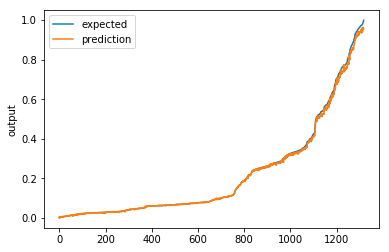

In [57]:
#Regression lift Chart
chart_regression(pred_hl4_do.flatten(),y_test)

### ReLU, sgd, 3 layers, early stopping and Model checkpoint  - score_relu_3l

In [40]:
# set up checkpoinAter
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_sgd3l.hdf5", verbose=1, save_best_only=True)

In [41]:
for i in range(10):
    print(i)
    
    # Build network
    model_relu = Sequential()

    model_relu.add(Dense(60, input_dim=x_train.shape[1], activation='relu'))  
    model_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_relu.add(Dense(10, activation='relu')) # Hidden 3
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_relu.load_weights('./best_weights_relu_sgd3l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 73s - loss: 0.0703 - val_loss: 0.0495

Epoch 00001: val_loss improved from inf to 0.04949, saving model to ./best_weights_relu_sgd3l.hdf5
Epoch 2/100
 - 4s - loss: 0.0393 - val_loss: 0.0298

Epoch 00002: val_loss improved from 0.04949 to 0.02975, saving model to ./best_weights_relu_sgd3l.hdf5
Epoch 3/100
 - 4s - loss: 0.0234 - val_loss: 0.0176

Epoch 00003: val_loss improved from 0.02975 to 0.01760, saving model to ./best_weights_relu_sgd3l.hdf5
Epoch 4/100
 - 4s - loss: 0.0131 - val_loss: 0.0092

Epoch 00004: val_loss improved from 0.01760 to 0.00921, saving model to ./best_weights_relu_sgd3l.hdf5
Epoch 5/100
 - 4s - loss: 0.0066 - val_loss: 0.0045

Epoch 00005: val_loss improved from 0.00921 to 0.00445, saving model to ./best_weights_relu_sgd3l.hdf5
Epoch 6/100
 - 4s - loss: 0.0031 - val_loss: 0.0020

Epoch 00006: val_loss improved from 0.00445 to 0.00205, saving model to ./best_weights_relu_sgd3l.hdf5
Epoch 7/100
 - 4s


Epoch 00007: val_loss did not improve from 0.00006
Epoch 8/100
 - 4s - loss: 1.0906e-04 - val_loss: 1.0106e-04

Epoch 00008: val_loss did not improve from 0.00006
Epoch 00008: early stopping
5
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 74s - loss: 0.0464 - val_loss: 0.0258

Epoch 00001: val_loss did not improve from 0.00006
Epoch 2/100
 - 4s - loss: 0.0180 - val_loss: 0.0118

Epoch 00002: val_loss did not improve from 0.00006
Epoch 3/100
 - 4s - loss: 0.0077 - val_loss: 0.0046

Epoch 00003: val_loss did not improve from 0.00006
Epoch 4/100
 - 4s - loss: 0.0028 - val_loss: 0.0015

Epoch 00004: val_loss did not improve from 0.00006
Epoch 5/100
 - 4s - loss: 9.2369e-04 - val_loss: 5.0229e-04

Epoch 00005: val_loss did not improve from 0.00006
Epoch 6/100
 - 4s - loss: 3.0357e-04 - val_loss: 1.7643e-04

Epoch 00006: val_loss did not improve from 0.00006
Epoch 7/100
 - 4s - loss: 1.3784e-04 - val_loss: 9.5531e-05

Epoch 00007: val_loss did not improve from 0.00006
Epoch

In [42]:
# Predict stars
pred_relu_3l_sgd = model_relu.predict(x_test)
print("Shape: {}".format(pred_relu_3l_sgd.shape))

Shape: (1318, 1)


In [43]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_3l_sgd = np.sqrt(mean_squared_error(y_test,pred_relu_3l_sgd))
print("Final score (RMSE): {}".format(score_relu_3l_sgd))
print('R2 score: %.2f' % r2_score(y_test, pred_relu_3l_sgd))

Final score (RMSE): 0.007269034627825022
R2 score: 1.00


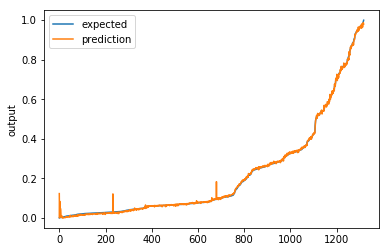

In [58]:
#Regression lift Chart
chart_regression(pred_relu_3l_sgd.flatten(),y_test)

### ReLU, sgd, 3 layer and dropout - score_relu_3l_do

In [44]:
    # Build network
    model_relu = Sequential()

    model_relu.add(Dense(50, input_dim=x_train.shape[1]))  
    model_relu.add(Dropout(0.1))
    model_relu.add(Dense(25, activation='relu')) # Hidden 2
    model_relu.add(Dense(10, activation='relu')) # Hidden 3
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 76s - loss: 0.0537 - val_loss: 0.0274
Epoch 2/100
 - 5s - loss: 0.0196 - val_loss: 0.0106
Epoch 3/100
 - 5s - loss: 0.0072 - val_loss: 0.0030
Epoch 4/100
 - 5s - loss: 0.0028 - val_loss: 7.9473e-04
Epoch 5/100
 - 4s - loss: 0.0021 - val_loss: 2.8032e-04
Epoch 6/100
 - 4s - loss: 0.0017 - val_loss: 1.4597e-04
Epoch 7/100
 - 5s - loss: 0.0014 - val_loss: 1.0794e-04
Epoch 8/100
 - 4s - loss: 0.0015 - val_loss: 9.0578e-05
Epoch 9/100
 - 4s - loss: 0.0016 - val_loss: 1.2277e-04
Epoch 00009: early stopping


In [45]:
# Predict stars
pred_hl3_do = model_relu.predict(x_test)

In [46]:
# Measure RMSE error.  RMSE is common for regression.
score_3l_do = np.sqrt(mean_squared_error(y_test,pred_hl3_do))
print("Final score (RMSE): {}".format(score_3l_do))
print('R2 score: %.2f' % r2_score(y_test, pred_hl3_do))

Final score (RMSE): 0.011080269701778889
R2 score: 1.00


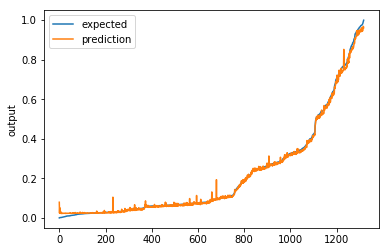

In [59]:
#Regression lift Chart
chart_regression(pred_hl3_do.flatten(),y_test)

### ReLU, rmsprop, 3 layers, early stopping and Model checkpoint  - score_relu_3l_rms

In [60]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_rms3l.hdf5", verbose=1, save_best_only=True)

In [ ]:
for i in range(10):
    print(i)
    
    # Build network
    model_relu = Sequential()

    model_relu.add(Dense(60, input_dim=x_train.shape[1], activation='relu'))  
    model_relu.add(Dense(30, activation='relu')) # Hidden 2
    model_relu.add(Dense(10, activation='relu')) # Hidden 3
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_relu],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_relu.load_weights('./best_weights_relu_rms3l.hdf5')

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 73s - loss: 0.0081 - val_loss: 4.8673e-05

Epoch 00001: val_loss improved from inf to 0.00005, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 2/100
 - 4s - loss: 1.8037e-04 - val_loss: 2.7065e-05

Epoch 00002: val_loss improved from 0.00005 to 0.00003, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 3/100
 - 4s - loss: 1.6002e-04 - val_loss: 2.4350e-05

Epoch 00003: val_loss improved from 0.00003 to 0.00002, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 4/100
 - 4s - loss: 1.2915e-04 - val_loss: 9.1019e-05

Epoch 00004: val_loss did not improve from 0.00002
Epoch 5/100
 - 4s - loss: 1.3189e-04 - val_loss: 1.4048e-05

Epoch 00005: val_loss improved from 0.00002 to 0.00001, saving model to ./best_weights_relu_rms3l.hdf5
Epoch 6/100
 - 4s - loss: 1.1719e-04 - val_loss: 1.5156e-05

Epoch 00006: val_loss did not improve from 0.00001
Epoch 00006: early stopping
1
Train on 3074 samples, validate on 1318 samples

In [ ]:
# Predict stars
pred_relu_3l_rms = model_relu.predict(x_test)
print("Shape: {}".format(pred_relu_3l_rms.shape))


In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_relu_3l_rms = np.sqrt(mean_squared_error(y_test,pred_relu_3l_rms))
print("Final score (RMSE): {}".format(score_relu_3l_rms))
print('R2 score: %.2f' % r2_score(y_test, pred_relu_3l_rms))

In [ ]:
#Regression lift Chart
chart_regression(pred_relu_3l_rms.flatten(),y_test)

### ReLU, rmsprop, 3 layer and dropout - score_relu_3l_do

In [ ]:
    # Build network
    model_relu = Sequential()

    model_relu.add(Dense(50, input_dim=x_train.shape[1]))  
    model_relu.add(Dropout(0.1))
    model_relu.add(Dense(25, activation='relu')) # Hidden 2
    model_relu.add(Dense(10, activation='relu')) # Hidden 3
    model_relu.add(Dense(1)) # Output
    model_relu.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_relu.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


In [ ]:
# Predict stars
pred_hl3_rms_do = model_relu.predict(x_test)

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_3l_rms_do = np.sqrt(mean_squared_error(y_test,pred_hl3_rms_do))
print("Final score (RMSE): {}".format(score_3l_rms_do))
print('R2 score: %.2f' % r2_score(y_test, pred_hl3_rms_do))

In [ ]:
#Regression lift Chart
chart_regression(pred_hl3_rms_do.flatten(),y_test)

## Sigmoid

### Sigmoid, adam, 2 layers, early stopping and Model checkpoint  - score_sig_adam2l

In [ ]:
# set up checkpointer
checkpointer_sigmoid = ModelCheckpoint(filepath="./best_weights_sigmoid_2l.hdf5", verbose=1, save_best_only=True)

In [ ]:
for i in range(10):
    print(i)
    
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(120, input_dim=x_train.shape[1], activation='sigmoid'))  
    model_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_sigmoid],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_sig.load_weights('./best_weights_sigmoid_2l.hdf5')

In [ ]:
# Predict stars
pred_sig_adam2l = model_sig.predict(x_test)
print("Shape: {}".format(pred_sig_adam2l.shape))

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_sig_adam2l = np.sqrt(mean_squared_error(y_test,pred_sig_adam2l))
print("Final score (RMSE): {}".format(score_sig_adam2l))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_adam2l))

In [ ]:
#Regression lift Chart
chart_regression(pred_sig_adam2l.flatten(),y_test)

### Sigmoid, adam, 3 layers, early stopping and Model checkpoint  - score_sig_adam3l

In [ ]:
# set up checkpointer
checkpointer_sigmoid = ModelCheckpoint(filepath="./best_weights_sigmoid_adam3l.hdf5", verbose=1, save_best_only=True)

In [ ]:
for i in range(10):
    print(i)
    
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(120, input_dim=x_train.shape[1], activation='sigmoid'))  
    model_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(60, activation='sigmoid')) # Hidden 3
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_sigmoid],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_sig.load_weights('./best_weights_sigmoid_adam3l.hdf5')

In [ ]:
# Predict stars
pred_sig_adam3l = model_sig.predict(x_test)
print("Shape: {}".format(pred_sig_adam3l.shape))

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_sig_adam3l = np.sqrt(mean_squared_error(y_test,pred_sig_adam3l))
print("Final score (RMSE): {}".format(score_sig_adam3l))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_adam3l))

In [ ]:
#Regression lift Chart
chart_regression(pred_sig_adam3l.flatten(),y_test)

### Sigmoid, adam, 4 layers, early stopping and Model checkpoint  - score_sig_adam4l

In [ ]:
# set up checkpointer
checkpointer_sigmoid = ModelCheckpoint(filepath="./best_weights_sigmoid_4l.hdf5", verbose=1, save_best_only=True)

In [ ]:
for i in range(10):
    print(i)
    
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(120, input_dim=x_train.shape[1], activation='sigmoid'))  
    model_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(60, activation='sigmoid')) # Hidden 3
    model_sig.add(Dense(10, activation='sigmoid')) # Hidden 4
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_sigmoid],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_sig.load_weights('./best_weights_sigmoid_4l.hdf5')

In [ ]:
# Predict stars
pred_sig_adam4l = model_sig.predict(x_test)
print("Shape: {}".format(pred_sig_adam4l.shape))

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_sig_adam4l = np.sqrt(mean_squared_error(y_test,pred_sig_adam4l))
print("Final score (RMSE): {}".format(score_sig_adam4l))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_adam4l))

In [ ]:
#Regression lift Chart
chart_regression(pred_sig_adam4l.flatten(),y_test)

### Sigmoid, adam, 4 layer and dropout - score_4l_sig_do

In [ ]:
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(80, input_dim=x_train.shape[1]))  
    model_sig.add(Dropout(0.1))
    model_sig.add(Dense(60, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(20, activation='sigmoid')) # Hidden 3
    model_sig.add(Dense(10, activation='sigmoid')) # Hidden 4
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


In [ ]:
# Predict stars
pred_sig_hl4_do = model_sig.predict(x_test)

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_4l_sig_do = np.sqrt(mean_squared_error(y_test,pred_sig_hl4_do))
print("Final score (RMSE): {}".format(score_4l_sig_do))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_hl4_do))

In [ ]:
#Regression lift Chart
chart_regression(pred_sig_hl4_do.flatten(),y_test)

### Sigmoid, sgd, 3 layers, early stopping and Model checkpoint  - score_sig_3l_sgd

In [ ]:
# set up checkpoinAter
checkpointer_sigmoid = ModelCheckpoint(filepath="./best_weights_sig_sgd3l.hdf5", verbose=1, save_best_only=True)

In [ ]:
for i in range(10):
    print(i)
    
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(60, input_dim=x_train.shape[1], activation='sigmoid'))  
    model_sig.add(Dense(30, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(10, activation='sigmoid')) # Hidden 3
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_sigmoid],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_sig.load_weights('./best_weights_sig_sgd3l.hdf5')

In [ ]:
# Predict stars
pred_sig_3l_sgd = model_sig.predict(x_test)
print("Shape: {}".format(pred_sig_3l_sgd.shape))


In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_sig_3l_sgd = np.sqrt(mean_squared_error(y_test,pred_sig_3l_sgd))
print("Final score (RMSE): {}".format(score_sig_3l_sgd))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_3l_sgd))

In [ ]:
#Regression lift Chart
chart_regression(pred_sig_hl4_do.flatten(),y_test)

### Sigmoid, sgd, 3 layer and dropout - score_3l_sig_do

In [ ]:
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(50, input_dim=x_train.shape[1]))  
    model_sig.add(Dropout(0.1))
    model_sig.add(Dense(25, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(10, activation='sigmoid')) # Hidden 3
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


In [ ]:
# Predict stars
pred_sig_hl3_do = model_sig.predict(x_test)

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_3l_sig_do = np.sqrt(mean_squared_error(y_test,pred_sig_hl3_do))
print("Final score (RMSE): {}".format(score_3l_sig_do))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_hl3_do))

In [ ]:
#Regression lift Chart
chart_regression(pred_sig_hl4_do.flatten(),y_test)

### Sigmoid, rmsprop, 3 layers, early stopping and Model checkpoint  - score_sig_3l_rms

In [ ]:
# set up checkpointer
checkpointer_sig = ModelCheckpoint(filepath="./best_weights_relu_rms3l.hdf5", verbose=1, save_best_only=True)

In [ ]:
for i in range(10):
    print(i)
    
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(60, input_dim=x_train.shape[1], activation='sigmoid'))  
    model_sig.add(Dense(30, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(10, activation='sigmoid')) # Hidden 3
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_sig],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_sig.load_weights('./best_weights_relu_rms3l.hdf5')

In [ ]:
# Predict stars
pred_sig_3l_rms = model_sig.predict(x_test)
print("Shape: {}".format(pred_sig_3l_rms.shape))


In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_sig_3l_rms = np.sqrt(mean_squared_error(y_test,pred_sig_3l_rms))
print("Final score (RMSE): {}".format(score_sig_3l_rms))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_3l_rms))

In [ ]:
#Regression lift Chart
chart_regression(pred_sig_hl4_do.flatten(),y_test)

### Sigmoid, rmsprop, 3 layer and dropout - score_relu_3l_do

In [ ]:
    # Build network
    model_sig = Sequential()

    model_sig.add(Dense(50, input_dim=x_train.shape[1]))  
    model_sig.add(Dropout(0.1))
    model_sig.add(Dense(25, activation='sigmoid')) # Hidden 2
    model_sig.add(Dense(10, activation='relu')) # Hidden 3
    model_sig.add(Dense(1)) # Output
    model_sig.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_sig.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


In [ ]:
# Predict stars
pred_sig_hl3_rms_do = model_sig.predict(x_test)

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_sig_3l_rms_do = np.sqrt(mean_squared_error(y_test,pred_sig_hl3_rms_do))
print("Final score (RMSE): {}".format(score_sig_3l_rms_do))
print('R2 score: %.2f' % r2_score(y_test, pred_sig_hl3_rms_do))

In [ ]:
#Regression lift Chart
chart_regression(pred_sig_hl3_rms_do.flatten(),y_test)

## Tanh

### Tanh, adam, 2 layers, early stopping and Model checkpoint  - score_tanh_adam2l

In [ ]:
# set up checkpointer
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_tanh_2l.hdf5", verbose=1, save_best_only=True)

In [ ]:
for i in range(10):
    print(i)
    
    # Build network
    model_tanh = Sequential()

    model_tanh.add(Dense(120, input_dim=x_train.shape[1], activation='tanh'))  
    model_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_tanh.load_weights('./best_weights_tanh_2l.hdf5')

In [ ]:
# Predict stars
pred_tanh_adam2l = model_tanh.predict(x_test)
print("Shape: {}".format(pred_tanh_adam2l.shape))

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_tanh_adam2l = np.sqrt(mean_squared_error(y_test,pred_tanh_adam2l))
print("Final score (RMSE): {}".format(score_tanh_adam2l))
print('R2 score: %.2f' % r2_score(y_test, v))

In [ ]:
#Regression lift Chart
chart_regression(pred_tanh_adam2l.flatten(),y_test)

### Tanh, adam, 3 layers, early stopping and Model checkpoint  - score_tanh_adam3l

In [ ]:
# set up checkpointer
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_sigmoid_adam3l.hdf5", verbose=1, save_best_only=True)

In [ ]:
for i in range(10):
    print(i)
    
    # Build network
    model_tanh = Sequential()

    model_tanh.add(Dense(120, input_dim=x_train.shape[1], activation='tanh'))  
    model_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(60, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_tanh.load_weights('./best_weights_sigmoid_adam3l.hdf5')

In [ ]:
# Predict stars
pred_tanh_adam3l = model_tanh.predict(x_test)
print("Shape: {}".format(pred_tanh_adam3l.shape))

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_tanh_adam3l = np.sqrt(mean_squared_error(y_test,pred_tanh_adam3l))
print("Final score (RMSE): {}".format(score_tanh_adam3l))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_adam3l))

In [ ]:
#Regression lift Chart
chart_regression(pred_tanh_adam3l.flatten(),y_test)

### Tanh, adam, 4 layers, early stopping and Model checkpoint  - score_tanh_adam4l

In [ ]:
# set up checkpointer
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_sigmoid_4l.hdf5", verbose=1, save_best_only=True)

In [ ]:
for i in range(10):
    print(i)
    
    # Build network
    model_tanh = Sequential()

    model_tanh.add(Dense(120, input_dim=x_train.shape[1], activation='tanh'))  
    model_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(60, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(10, activation='tanh')) # Hidden 4
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_tanh.load_weights('./best_weights_sigmoid_4l.hdf5')

In [ ]:
# Predict stars
pred_tanh_adam4l = model_tanh.predict(x_test)
print("Shape: {}".format(pred_tanh_adam4l.shape))

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_tanh_adam4l = np.sqrt(mean_squared_error(y_test,pred_tanh_adam4l))
print("Final score (RMSE): {}".format(score_tanh_adam4l))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_adam4l))

In [ ]:
#Regression lift Chart
chart_regression(pred_tanh_adam4l.flatten(),y_test)

### Tanh, adam, 4 layer and dropout - score_4l_tanh_do

In [ ]:
    # Build network
    model_tanh = Sequential()

    model_tanh.add(Dense(80, input_dim=x_train.shape[1]))  
    model_tanh.add(Dropout(0.1))
    model_tanh.add(Dense(60, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(20, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(10, activation='tanh')) # Hidden 4
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


In [ ]:
# Predict stars
pred_tanh_hl4_do = model_tanh.predict(x_test)

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_4l_tanh_do = np.sqrt(mean_squared_error(y_test,pred_tanh_hl4_do))
print("Final score (RMSE): {}".format(score_4l_tanh_do))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_hl4_do))

In [ ]:
#Regression lift Chart
chart_regression(pred_tanh_hl4_do.flatten(),y_test)

### Tanh, sgd, 3 layers, early stopping and Model checkpoint  - score_tanh_3l_sgd

In [ ]:
# set up checkpoinAter
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_tanh_sgd3l.hdf5", verbose=1, save_best_only=True)

In [ ]:
for i in range(10):
    print(i)
    
    # Build network
    model_tanh = Sequential()

    model_tanh.add(Dense(60, input_dim=x_train.shape[1], activation='tanh'))  
    model_tanh.add(Dense(30, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(10, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_tanh.load_weights('./best_weights_tanh_sgd3l.hdf5')

In [ ]:
# Predict stars
pred_tanh_3l_sgd = model_tanh.predict(x_test)
print("Shape: {}".format(pred_tanh_3l_sgd.shape))


In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_tanh_3l_sgd = np.sqrt(mean_squared_error(y_test,pred_tanh_3l_sgd))
print("Final score (RMSE): {}".format(score_tanh_3l_sgd))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_3l_sgd))

In [ ]:
#Regression lift Chart
chart_regression(pred_tanh_3l_sgd.flatten(),y_test)

### Tanh, sgd, 3 layer and dropout - score_3l_tanh_do

In [ ]:
    # Build network
    model_tanh = Sequential()
    model_tanh.add(Dense(50, input_dim=x_train.shape[1]))  
    model_tanh.add(Dropout(0.1))
    model_tanh.add(Dense(25, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(10, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 

In [ ]:
# Predict stars
pred_tanh_hl3_do = model_tanh.predict(x_test)

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_3l_tanh_do = np.sqrt(mean_squared_error(y_test,pred_tanh_hl3_do))
print("Final score (RMSE): {}".format(score_3l_tanh_do))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_hl3_do))

In [ ]:
#Regression lift Chart
chart_regression(pred_tanh_hl3_do.flatten(),y_test)

### Tanh, rmsprop, 3 layers, early stopping and Model checkpoint  - score_tanh_3l_rms

In [ ]:
# set up checkpointer
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_tanh_rms3l.hdf5", verbose=1, save_best_only=True)

In [ ]:
for i in range(10):
    print(i)
    
    # Build network
    model_tanh = Sequential()
    model_tanh.add(Dense(60, input_dim=x_train.shape[1], activation='tanh'))  
    model_tanh.add(Dense(30, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(10, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_tanh.load_weights('./best_weights_tanh_rms3l.hdf5')

In [ ]:
# Predict stars
pred_tanh_3l_rms = model_sig.predict(x_test)
print("Shape: {}".format(pred_tanh_3l_rms.shape))

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_tanh_3l_rms = np.sqrt(mean_squared_error(y_test,pred_tanh_3l_rms))
print("Final score (RMSE): {}".format(score_tanh_3l_rms))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_3l_rms))

In [ ]:
#Regression lift Chart
chart_regression(pred_tanh_3l_rms.flatten(),y_test)

### Tanh, rmsprop, 3 layer and dropout - score_tanh_3l_do

In [ ]:
    # Build network
    model_tanh = Sequential()

    model_tanh.add(Dense(50, input_dim=x_train.shape[1]))  
    model_tanh.add(Dropout(0.1))
    model_tanh.add(Dense(25, activation='tanh')) # Hidden 2
    model_tanh.add(Dense(10, activation='tanh')) # Hidden 3
    model_tanh.add(Dense(1)) # Output
    model_tanh.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_tanh.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100) 


In [ ]:
# Predict stars
pred_tanh_hl3_rms_do = model_tanh.predict(x_test)

In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score_tanh_3l_rms_do = np.sqrt(mean_squared_error(y_test,pred_tanh_hl3_rms_do))
print("Final score (RMSE): {}".format(score_tanh_3l_rms_do))
print('R2 score: %.2f' % r2_score(y_test, pred_tanh_hl3_rms_do))

In [ ]:
#Regression lift Chart
chart_regression(pred_tanh_hl3_rms_do.flatten(),y_test)